# Projected-Multipole Correlation Function Covariance

## Setup

In [1]:
import warnings
import numpy as np
from scipy.interpolate import CubicSpline, interp1d, interp2d, UnivariateSpline
from scipy.special import legendre
from scipy.optimize import curve_fit
from sympy.physics.wigner import wigner_3j
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm
plt.rcParams['text.usetex'] = False
from mcfit import P2xi, xi2P, Hankel
from avgem import avg
np.set_printoptions(linewidth=100)

In [2]:
def l2mu(L, Nmu, avg=True):
    l_max = 2 * L.shape[0] - 2
    ell = range(0, l_max+1)
    
    mu_edge = np.linspace(0, 1, num=Nmu+1, endpoint=True)
    mu_cent = 0.5 * (mu_edge[1:] + mu_edge[:-1])
    dmu = 1 / Nmu
    
    M = np.zeros((Nmu, L.shape[1]))
    
    for i, l in enumerate(ell):
        if avg:
            leg = np.diff(legendre(l).integ()(mu_edge)) / dmu
        else:
            leg = legendre(l)(mu_cent)
        M += L[i] * leg[:, None]
    
    return M

def mu2l(M, l_max):
    Nmu = M.shape[0]
    mu_edge = np.linspace(-1, 1, num=Nmu+1, endpoint=True)
    mu_cent = 0.5 * (mu_edge[1:] + mu_edge[:-1])
    dmu = 2 / Nmu
    
    ell = range(0, l_max+1, 2)
    
    L = np.zeros((len(ell), M.shape[1]))
    
    for i, l in enumerate(ell):
        L[i] = legendre(l)(mu_cent) @ M * (2*l+1) * dmu / 2
    
    return L

def inv_pole(L, l_inv_max):
    """Inverse multipole moments.

    Solve A b = (1, 0, 0, ...)
    
    L is 2D, with ell in axis=0
    """
    l_max = 2 * L.shape[0] - 2
    ell = range(0, l_max+1, 2)

    ell_inv = range(0, l_inv_max+1, 2)
    A = np.zeros((L.shape[1], len(ell_inv), len(ell_inv)))

    for i, li in enumerate(ell_inv):
        for j, lj in enumerate(ell_inv):  # (2*lj+1) can be dropped
            for l in range(abs(li-lj), min(li+lj, l_max) + 1, 2):
                w3sq = wigner_3j(l, li, lj, 0, 0, 0)**2
                A[:, i, j] += L[l//2] * float(w3sq)

    mono = np.zeros((1, len(ell_inv)))
    mono[0, 0] = 1

    L_inv = np.linalg.solve(A, mono)
    L_inv = L_inv.T

    return L_inv

In [3]:
# We want matching s for different l, but lowring=False with an even N is
# problematic, because the forward and backward transformation matrix are no
# longer inverse of each other -- their product is the identity matrix with
# some huge corner oscillations
# Therefore, I use Odd N (powers of 3) here
lowring=False
lgkmin, lgkmax = -6, 2
Nk = 3645

k = np.logspace(lgkmin, lgkmax, num=Nk, endpoint=False)
T1 = P2xi(k, N=len(k), lowring=lowring)
s = T1.y # NOTE: when lowring=True, this `s` is only appropriate for l=0
T2 = xi2P(s, N=len(s), lowring=lowring)
assert np.allclose(T2.y, k, rtol=1e-10, atol=0)

def get_s(k, lowring=False):
    return P2xi(k, N=len(k), lowring=lowring).y

s = get_s(k)

def get_ell(l_max):
    return np.arange(0, l_max+1, 2)

def get_const(z_bin):
    const = {}
    
    const['alpha_Q'] = 0.2
    const['alpha_P'] = 0.02
    
    if z_bin == 1:
        const['S0'] = 1.296222442253179615e+05
        const['W0'] = 4.012851294209899322e+01
        
        const['SS0'] = 2.412316246590063606e+00
        const['WS0'] = 7.304557958097776397e-04
        const['WW0'] = 2.310708077931338384e-07
    elif z_bin == 3:
        const['S0'] = 2.825013572057803976e+05
        const['W0'] = 4.542545521052436186e+01
        
        const['SS0'] = 5.849509325047407060e+00
        const['WS0'] = 8.995672356970692719e-04
        const['WW0'] = 2.158460117153556665e-07
    else:
        raise NotImplementedError
    
    const['S0'] *= const['alpha_Q'] * (1 + const['alpha_P'])
    const['W0'] *= const['alpha_Q']
    
    const['SS0'] *= const['alpha_Q'] * (1 + const['alpha_P'])**2
    const['WS0'] *= const['alpha_Q'] * (1 + const['alpha_P'])
    const['WW0'] *= const['alpha_Q']
    
    const['Veff'] = const['W0']**2 / const['WW0']
    const['Pshot'] = const['S0'] / const['W0']
    
    return const

def rescale_kk(k, power):
    return k[:, None]**power * k**power

In [4]:
def get_sukhdeep_const(z_bin):
    const = {}
    
    if z_bin == 1:
        const['alpha_Q'] = 448758 / 479778
        const['alpha_P'] = 448758 / 2398890
        
        const['S0'] = 27897.377075
        const['W0'] = 8.63764468373
        
        const['SS0'] = 0.519140394129
        const['WS0'] = 0.000157221955385
        const['WW0'] = 4.9740651819e-08
    else:
        raise NotImplementedError
    
    const['S0'] *= const['alpha_Q'] * (1 + const['alpha_P'])
    const['W0'] *= const['alpha_Q']
    
    const['SS0'] *= const['alpha_Q'] * (1 + const['alpha_P'])**2
    const['WS0'] *= const['alpha_Q'] * (1 + const['alpha_P'])
    const['WW0'] *= const['alpha_Q']
    
    const['Veff'] = const['W0']**2 / const['WW0']
    const['Pshot'] = const['S0'] / const['W0']
    
    return const

get_sukhdeep_const(1),  get_const(1)

({'Pshot': 3833.9284910885035,
  'S0': 30974.993040153036,
  'SS0': 0.6842402821346878,
  'Veff': 1402978681.9942057,
  'W0': 8.07917860548276,
  'WS0': 0.0001745665537199836,
  'WW0': 4.6524674805828537e-08,
  'alpha_P': 0.18706901942148244,
  'alpha_Q': 0.9353450971074122},
 {'Pshot': 3294.781675578048,
  'S0': 26442.937821964864,
  'SS0': 0.5019547645904605,
  'Veff': 1393769785.3948088,
  'W0': 8.025702588419799,
  'WS0': 0.00014901298234519465,
  'WW0': 4.621416155862677e-08,
  'alpha_P': 0.02,
  'alpha_Q': 0.2})

In [5]:
def deflate(M):
    if M.ndim == 4 and M.shape[0] == M.shape[1] == M.shape[2] == M.shape[3]:
        warnings.warn("Ambiguity in deflation")
    
    if M.ndim == 2 and M.shape[0] == M.shape[1]:
        return M
    if M.ndim == 4 and M.shape[0] == M.shape[1] and M.shape[2] == M.shape[3]:
        return M.swapaxes(1, 2).reshape(M.shape[0] * M.shape[2], -1)
    if M.ndim == 4 and M.shape[0] == M.shape[2] and M.shape[1] == M.shape[3]:
        return M.reshape(M.shape[0] * M.shape[1], -1)
    
    raise ValueError

def inflate(M, shape):
    if M.ndim != 2 or M.shape[0] != M.shape[1]:
        raise ValueError
        
    if len(shape) == 4 and shape[0] == shape[1] == shape[2] == shape[3]:
        warnings.warn("Ambiguity in inflation")
    
    if M.shape == shape:
        return M
    if len(shape) == 4 and shape[0] == shape[1] and shape[2] == shape[3]:
        shape = (shape[0], shape[2], shape[1], shape[3])
        return M.reshape(shape).swapaxes(1, 2)
    if len(shape) == 4 and shape[0] == shape[2] and shape[1] == shape[3]:
        return M.reshape(shape)
    
    raise ValueError

def lowrank(M, rank):
    """Return the low-rank part of a matrix."""
    w, v = np.linalg.eigh(deflate(M))
    if rank < 0 or rank >= len(w):
        raise ValueError
    
    idx = np.argsort(np.abs(w))[len(w)-rank:]
    
    Mlow = np.zeros_like(v)
    Mlow += sum(w[i] * v[:, [i]] * v[:, i] for i in idx)
    
    Mlow = inflate(Mlow, M.shape)
    return Mlow

def smooth_eig(M, rank, rank0=0):
    w, v = np.linalg.eigh(deflate(M))
    
    idx = np.argsort(np.abs(w))[len(w)-rank:len(w)-rank0]
    idx = idx[::-1]
    
    v_smooth = np.zeros((v.shape[0], rank))
    if M.ndim == 2:
        x = np.arange(len(w))
        for ith, i  in enumerate(idx):
            v_smooth[:, ith] = UnivariateSpline(x, v[:, i])(x)
    elif M.ndim == 4:
        x = np.arange(M.shape[-1])
        for ith, i in enumerate(idx):
            for j in range(M.shape[0]):
                v_smooth[j*len(x):(j+1)*len(x), ith] = \
                    UnivariateSpline(x, v[j*len(x):(j+1)*len(x), i])(x)
    else:
        raise ValueError
    
    return w[idx], v[:, idx], v_smooth

def plteig(M, rank, rank0=0):
    w, v, v_smooth = smooth_eig(M, rank, rank0=rank0)
    
    plt.axhline(0, c='k')
    alphas = np.linspace(1, 0.5, rank)
    ith = rank0
    for val, vec, vec_smooth, alpha in zip(w, v.T, v_smooth.T, alphas):
        ith += 1
        l, = plt.plot(vec, label=f"$\lambda_{{{ith}}}={val:.2g}$", alpha=alpha)
        plt.plot(vec_smooth, c=l.get_color(), alpha=alpha)
    plt.legend()
    
    plt.show()

def pltmat(M, scale='symlog', vlim=None, linthresh=None, linscale=1, sav=None):
    """Visualize a matrix.
    
    Parameters
    ----------
    M : 2d or 4d ndarray, or array_like of 2d ndarray
    """
    width = height = 4
    
    M = np.asarray(M)
    if M.ndim == 2 and M.shape[0] == M.shape[1]:
        Ms = [M]
    elif M.ndim == 3 and M.shape[1] == M.shape[2]:
        Ms = M
        width *= M.shape[0]
    elif M.ndim == 4:
        Ms = [deflate(M)]
        width *= M.shape[1]
        height *= M.shape[0]
    else:
        raise ValueError
    
    num = len(Ms)
    _, axes = plt.subplots(ncols=num, squeeze=False, figsize=(width, height))
    axes = axes.ravel()
    
    if Ms[0].shape[0] > 1000:
        method = "matshow"
    else:
        method = "pcolormesh"
    
    if vlim is None:
        vlim = np.abs(Ms).max()
        
    if scale == 'linear':
        for i, M in enumerate(Ms):
            plot = getattr(axes[i], method)
            im = plot(M, vmin=-vlim, vmax=vlim, cmap='RdBu_r')
            axes[i].set_aspect('equal', adjustable='box')
    elif scale == 'symlog':
        if linthresh is None:
            linthresh = 1e-4 * vlim
        for i, M in enumerate(Ms):
            plot = getattr(axes[i], method)
            im = plot(M, norm=SymLogNorm(linthresh=linthresh, linscale=linscale,
                                         vmin=-vlim, vmax=vlim), cmap='RdBu_r')
            axes[i].set_aspect('equal', adjustable='box')
    else:
        raise ValueError
        
    plt.colorbar(im, ax=axes)
    
    if sav:
        plt.savefig(sav)
        
def cov2cor(cov, cov_norm=None):
    """Normalize a matrix by the diagonal."""
    if cov_norm is None:
        cov_norm = cov
    
    cor = deflate(cov_norm).diagonal()
    cor = np.sqrt(cor[:, None] * cor)
    cor = deflate(cov) / cor
    
    cor = inflate(cor, cov.shape)
    return cor

def cor2cov(cor, cov_norm):
    """Rescale a correlation matrix using the diagonal of a covariance matrix."""
    cov_norm = deflate(cov_norm).diagonal()
    cov_norm = np.sqrt(cov_norm[:, None] * cov_norm)
    cov = deflate(cor) * cov_norm
    
    cov = inflate(cov, cor.shape)
    return cov

## Hankel transforms, window multipoles, window matrix

In [6]:
def get_H(k, l_max=20, lowring=False):
    """Return Hankel circulant matrix for all (l, k, k')"""
    ell = get_ell(l_max)
    return np.stack([P2xi(k, l=l, N=len(k), lowring=lowring).matrix(full=False)[2] for l in ell], axis=0)
# xi2P should give the same result with matrix(full=False)

In [7]:
%%time

H = get_H(k)

CPU times: user 754 ms, sys: 1.33 s, total: 2.08 s
Wall time: 2.08 s


In [8]:
def get_Qls(s, w_type, z_bin):
    """Return Q_l(s) for all (l, s)"""
    Ql_file = f"patchy/Ql_model_z{z_bin}_{w_type}.dat"
    Ql_data = np.loadtxt(Ql_file, unpack=True)
    _s = Ql_data[0]
    _Q = Ql_data[1:]
    
    _Q *= get_const(z_bin)['alpha_Q']**2
    
    if w_type == 'nw2_w2':
        _Q *= 1 + get_sukhdeep_const(z_bin)['alpha_P']
    elif w_type == 'w2_w2':
        _Q *= (1 + get_sukhdeep_const(z_bin)['alpha_P'])**2

    Q = interp1d(_s, _Q, bounds_error=False, fill_value=0)(s)
#     Q = CubicSpline(_s, _Q, axis=1)(s)
#     Q[:, s<_s.min()] = 0
#     Q[:, s>_s.max()] = 0
    
    return Q

def get_Qlls(s, l_max, lp_max, l_Q_max, w_type, z_bin):
    """Return Q_ll(s) for all (l, l', s)"""
    Qls = get_Qls(s, w_type, z_bin)
    
    ell = get_ell(l_max)
    ell_prime = get_ell(lp_max)
    
    Q = np.zeros((len(ell), len(ell_prime), len(s)))
    
    for i, l in enumerate(ell):
        for j, lp in enumerate(ell_prime):
            for l_Q in range(abs(l-lp), min(l+lp, l_Q_max) + 1, 2):
                w3sq = wigner_3j(l, lp, l_Q, 0, 0, 0)**2
                Q[i, j] += float(w3sq) * Qls[l_Q//2]
            Q[i, j] *= (-1)**(i+j)
            
    return Q

def get_Qllkk(k, l_max, lp_max, l_Q_max, w_type='nw2_nw2', z_bin=1):
    """Return Q_ll(k, k) for all (l, l', k, k')"""
    s = get_s(k)
    
    ell = get_ell(l_max)
    ell_prime = get_ell(lp_max)
    
    Qlls = get_Qlls(s, l_max, lp_max, l_Q_max, w_type, z_bin)
    
    Q = H[:len(ell), None, ...] * Qlls[..., None, :]
    
    for j, lp in enumerate(ell_prime):
        for i, l in enumerate(ell):
            #Q[i, j] = Q[i, j] @ H[j]
            _, Q[i, j] = P2xi(k, l=lp, N=len(k),
                              lowring=lowring)(Q[i, j], axis=1,
                                               extrap=False, convonly=True)

    dlnk = np.diff(np.log(k)).mean()
    Q *= 2 * np.pi**2 / dlnk / rescale_kk(k, 1.5)
    
    return Q

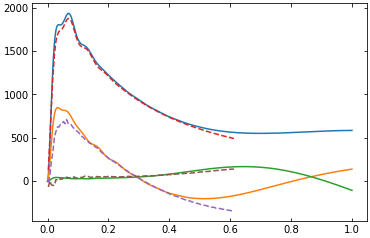

In [10]:
def plt_Plk(k, z_bin):
    Pl_file = f"patchy/Pl_model_z{z_bin}.dat"
    Pl_data = np.loadtxt(Pl_file, unpack=True)
    _k = Pl_data[0]
    _P = Pl_data[1:]
    
    Pl_file = f"patchy/Pl_data_z{z_bin}.npy"
    Pb = np.load(Pl_file).mean(axis=0)
    kb = np.arange(Pb.shape[1] + 1) * 0.005
    kb = 0.5 * (kb[1:] + kb[:-1])
    
    plt.plot(_k, (_k*_P).T)
    plt.plot(kb, (kb*Pb).T, ls='--')
#     plt.xscale('log')
#     plt.yscale('symlog', linthreshy=10)

plt_Plk(1, 1)

In [9]:
def get_Plk(k, z_bin, add_shot, kcut=0.4, hack=False):
    """Return P_l(k) for all (l, k)"""
    Pl_file = f"patchy/Pl_model_z{z_bin}.dat"
    Pl_data = np.loadtxt(Pl_file, unpack=True)
    _k = Pl_data[0]
    _P = Pl_data[1:]
    
    _P = _P[:, _k<kcut]
    _k = _k[_k<kcut]
    
    if hack:
        _P[0] *= 1 + 0.035*(1 - np.tanh((_k-0.13)/0.05))
    
    # interpolate
    P = CubicSpline(_k, _P, axis=1)(k)
    # extrapolate as pow-law on the low-k side
    k_left = k[k < _k.min()]
    lnP_left = interp1d(np.log(_k[:2]), np.log(_P[:, :2]), axis=1, kind='linear',
                        fill_value='extrapolate', assume_sorted=True)(np.log(k_left))
    P[:, k < _k.min()] = np.exp(lnP_left)
    # extrapolate monopole as pow-law on the high-k side
    k_right = k[k > _k.max()]
    lnP_right = interp1d(np.log(_k[-2:]), np.log(_P[0, -2:] * np.array([1, 1])), kind='linear',
                        fill_value='extrapolate', assume_sorted=True)(np.log(k_right))
    P[:, k > _k.max()] = np.exp(lnP_right)
    # zero at the high-k end
#     P[:, k > _k.max()] = 0
    P[1:, k > _k.max()] = 0
    
#     # periodic interpolation
#     P = CubicSpline(_k, _P, axis=1)(k)
#     crush_width = 300
#     P[:, :crush_width] = P[:, -crush_width:] = 0
#     mask = (k < k[crush_width]) | (k > _k.min()) & (k < _k.max()) | (k >= k[-crush_width])
#     lnk = np.log(k)
#     P = CubicSpline(lnk[mask], P[:, mask], axis=1, bc_type='periodic')(lnk)
    
    if add_shot:
        P[0] += get_sukhdeep_const(z_bin)['Pshot']
    
    return P

def get_Pllk(k, l_max, lp_max, l_P_max, z_bin=1, add_shot=False):
    """Return P_ll(k) for all (l, l', k)"""
    Plk = get_Plk(k, z_bin, add_shot)
    
    # ugly hack to correct P_0 to reproduce xi_0, does not have shot noise!
#     _, Plk[0] = hack_P0(k, z_bin, plot=False)
    
    ell = get_ell(l_max)
    ell_prime = get_ell(lp_max)
    
    P = np.zeros((len(ell), len(ell_prime), len(k)))
    
    for i, l in enumerate(ell):
        for j, lp in enumerate(ell_prime):
            for l_P in range(abs(l-lp), min(l+lp, l_P_max) + 1, 2):
                w3sq = wigner_3j(l, l_P, lp, 0, 0, 0)**2
                P[i, j] += float(w3sq) * Plk[l_P//2]
            P[i, j] *= (2*lp+1)
            
    return P

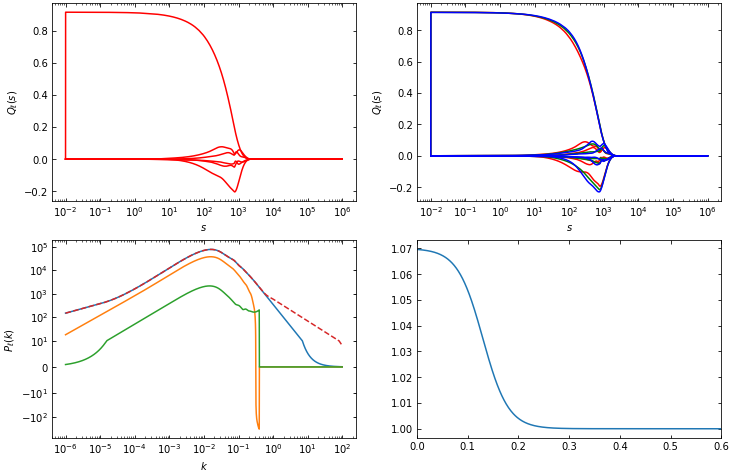

In [11]:
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.plot(s, get_Qls(s, w_type='w_w', z_bin=1).T / get_sukhdeep_const(z_bin=1)['W0'], 'r-')
plt.xscale('log')
plt.xlabel('$s$')
plt.ylabel('$Q_\ell(s)$')
plt.subplot(222)
plt.plot(s, get_Qls(s, w_type='nw2_nw2', z_bin=1).T / get_sukhdeep_const(z_bin=1)['WW0'], 'r-')
plt.plot(s, get_Qls(s, w_type='nw2_w2', z_bin=1).T / get_sukhdeep_const(z_bin=1)['WS0'], 'g-')
plt.plot(s, get_Qls(s, w_type='w2_w2', z_bin=1).T / get_sukhdeep_const(z_bin=1)['SS0'], 'b-')
plt.xscale('log')
plt.xlabel('$s$')
plt.ylabel('$Q_\ell(s)$')
plt.subplot(223)
plt.plot(k, get_Plk(k, z_bin=1, add_shot=False).T, ls='-')
plt.plot(k, get_Plk(k, z_bin=1, add_shot=False, kcut=1)[0], ls='--')
# plt.ylim(1, 1e5)
plt.xscale('log')
plt.yscale('symlog', linthreshy=10)
plt.xlabel('$k$')
plt.ylabel('$P_\ell(k)$')
plt.subplot(224)
plt.plot(k, get_Plk(k, z_bin=1, add_shot=False, hack=True)[0]
             / get_Plk(k, z_bin=1, add_shot=False)[0])
plt.xlim(0, 0.6)
plt.show()

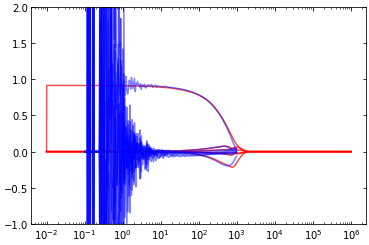

In [494]:
mu = np.arange(-0.99, 1, 0.02)
s_ = np.loadtxt("z1/win1_SW_3D_r_mu.dat", unpack=True)[0][::len(mu)]
Vsh = np.loadtxt("z1/win1_SW_3D_r_mu.dat", unpack=True)[3][::len(mu)]
Qmu = np.loadtxt("z1/win1_SW_3D_r_mu.dat", unpack=True)[2].reshape(len(mu), len(s_), order='F')
Qmu /= Vsh
Ql = mu2l(Qmu, l_max=16)

plt.plot(s, get_Qls(s, w_type='nw2_w2', z_bin=1).T / get_sukhdeep_const(z_bin=1)['WS0'], 'r-', alpha=0.7)
plt.plot(s_, Ql.T * get_sukhdeep_const(1)['alpha_Q']**2 * (1 + get_sukhdeep_const(1)['alpha_P']) \
         / get_sukhdeep_const(1)['WS0'], 'b-', alpha=0.5)
plt.xscale('log')
plt.ylim(-1, 2)
plt.show()

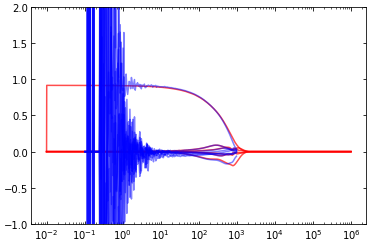

In [496]:
mu = np.arange(-0.99, 1, 0.02)
s_ = np.loadtxt("z1/win1_WW_3D_r_mu.dat", unpack=True)[0][::len(mu)]
Vsh = np.loadtxt("z1/win1_WW_3D_r_mu.dat", unpack=True)[3][::len(mu)]
Qmu = np.loadtxt("z1/win1_WW_3D_r_mu.dat", unpack=True)[2].reshape(len(mu), len(s_), order='F')
Qmu /= Vsh
Ql = mu2l(Qmu, l_max=16)

plt.plot(s, get_Qls(s, w_type='nw2_nw2', z_bin=1).T / get_sukhdeep_const(z_bin=1)['WW0'], 'r-', alpha=0.7)
plt.plot(s_, Ql.T * get_sukhdeep_const(1)['alpha_Q']**2 / get_sukhdeep_const(1)['WW0'], 'b-', alpha=0.5)
plt.xscale('log')
# plt.xlim(200, 1000)
plt.ylim(-1, 2)
plt.show()

In [497]:
def process_perp_win_file(win_file, w_type, num_pi=100):
    rp = np.loadtxt(win_file, unpack=True)[0][::num_pi]
    pi = np.loadtxt(win_file, unpack=True)[1][:num_pi]
    dpi = np.diff(pi).mean()
    Vsh = np.loadtxt(win_file, unpack=True)[3][::num_pi]
    Ash = Vsh / dpi
    # print(np.diff(np.logspace(-1, 3, 201)**2) * np.pi / Ash)
    
    Qrp = np.loadtxt(win_file, unpack=True)[2].reshape(len(rp), len(pi))
    Qrp = Qrp.sum(axis=1) / Ash
    
    np.savetxt(f"patchy/Qperp_data_z1_{w_type}.dat", np.column_stack((rp, Qrp)))

process_perp_win_file("z1/win1_WW_projected_rp_pi.dat", "nw2_nw2")
process_perp_win_file("z1/win1_SW_projected_rp_pi.dat", "nw2_w2")
process_perp_win_file("z1/win1_SS_projected_rp_pi.dat", "w2_w2")

process_perp_win_file("z1/RR_wt_pair_count_projected.dat", "w_w")  # normalization, linear bins

/global/homes/t/tiger/.conda/envs/rich/lib/python3.6/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


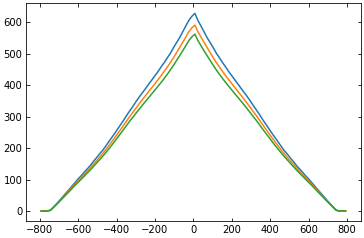

In [10]:
def get_Qrppi(plot=False):
    win_file = "z1/RR_wt_pair_count_projected.dat"
    w_type = "w_w"
    num_pi=100
    
    rp = np.loadtxt(win_file, unpack=True)[0][::num_pi]
    pi = np.loadtxt(win_file, unpack=True)[1][:num_pi]
    dpi = np.diff(pi).mean()
    Vsh = np.loadtxt(win_file, unpack=True)[3][::num_pi]
    Ash = Vsh / dpi
    
    Q = np.loadtxt(win_file, unpack=True)[2].reshape(len(rp), len(pi))
    Q /= Ash[:, None]
    
    if plot:
        plt.plot(pi, Q[0])
        plt.plot(pi, Q[14])
        plt.plot(pi, Q[29])
    
    return interp2d(pi, rp, Q, fill_value=0)

get_Qrppi(plot=True);

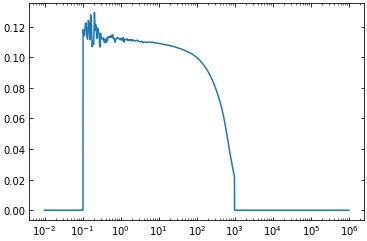

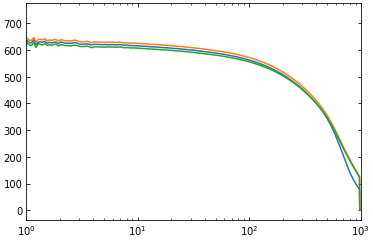

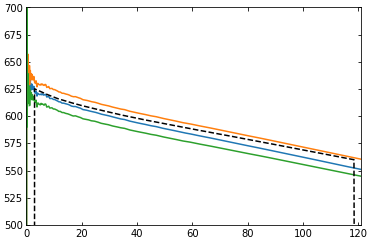

In [13]:
def get_Pperp(k, z_bin, add_shot):
    """Return P_perp(k)"""
    P = get_Plk(k, z_bin, add_shot)
    for i in range(P.shape[0]):
        l = 2 * i
        P[i] *= legendre(l)(0)
    P = P.sum(axis=0)
    return P

def get_Qrp(s, w_type, z_bin):
    """Return Q_perp(s) for all s"""
    Q_file = f"patchy/Qperp_data_z{z_bin}_{w_type}.dat"
    Q_data = np.loadtxt(Q_file, unpack=True)
    _s = Q_data[0]
    _Q = Q_data[1]
    
    if w_type == 'w_w':  # this is the normalization, for which Sukhdeep uses effectively "DR"
        _Q *= get_sukhdeep_const(z_bin)['alpha_P']
    else:
        _Q *= get_sukhdeep_const(z_bin)['alpha_Q']**2
    
    if w_type == 'nw2_w2':
        _Q *= 1 + get_sukhdeep_const(z_bin)['alpha_P']
    elif w_type == 'w2_w2':
        _Q *= (1 + get_sukhdeep_const(z_bin)['alpha_P'])**2

    Q = interp1d(_s, _Q, bounds_error=False, fill_value=0)(s)
    
    return Q

def get_Qkk(k, w_type='nw2_nw2', z_bin=1):
    """Return Q_perp(k, k) for all (k, k')"""
    s = get_s(k)
    
    Q = get_Qrp(s, w_type, z_bin)
    
    H = Hankel(k, nu=0, N=len(k), lowring=lowring).matrix(full=False)[2]
    
    Q = H * Q[None, :]
    
    _, Q = Hankel(k, nu=0, N=len(k), lowring=lowring)(Q, axis=1, extrap=False, convonly=True)

    dlnk = np.diff(np.log(k)).mean()
    Q *= 2 * np.pi / dlnk / rescale_kk(k, 1)
    
    return Q

plt.plot(s, get_Qrp(s, 'nw2_w2', 1))
plt.xscale('log')
plt.show()

plt.plot(s, get_Qrp(s, 'nw2_nw2', 1) / get_sukhdeep_const(1)['WW0'])
plt.plot(s, get_Qrp(s, 'nw2_w2', 1) / get_sukhdeep_const(1)['WS0'])
plt.plot(s, get_Qrp(s, 'w2_w2', 1) / get_sukhdeep_const(1)['SS0'])
plt.xscale('log')
plt.xlim(1, 1000)
plt.show()

plt.plot(s, get_Qrp(s, 'nw2_nw2', 1) / get_sukhdeep_const(1)['WW0'])
plt.plot(s, get_Qrp(s, 'nw2_w2', 1) / get_sukhdeep_const(1)['WS0'])
plt.plot(s, get_Qrp(s, 'w2_w2', 1) / get_sukhdeep_const(1)['SS0'])
plt.plot(s, get_Qrp(s, 'w_w', 1) / get_sukhdeep_const(1)['W0'], 'k--')
plt.xlim(0, 121)
plt.ylim(500, 700)
plt.show()

In [11]:
def get_Cllkk(k, l_max=16, l_P_max=4, l_Q_max=10, z_bin=1, simple_shot=False):
    """Return C_{l, l}(k, k) for all (l, l', k, k'), l[0]=perp and l'[0]=perp"""
    P = get_Pllk(k, l_max, l_max+l_P_max, l_P_max, z_bin=z_bin, add_shot=simple_shot)
    
    QW = get_Qllkk(k, l_max+l_P_max, l_max+l_P_max, l_Q_max, w_type='nw2_nw2', z_bin=z_bin)
    
    ell = get_ell(l_max)
    
    C = np.zeros((len(ell), len(ell), len(k), len(k)))
    
    for i in range(QW.shape[0]):
        for j in range(QW.shape[1]):
            print(i, j, flush=True)
            C += P[:, i][:, None, :, None] * QW[[i], [j]] * P[:, j][None, :, None, :]
    
    if not simple_shot:
        QX = get_Qllkk(k, l_max+l_P_max, l_max, l_Q_max, w_type='nw2_w2', z_bin=z_bin)
        QS = get_Qllkk(k, l_max, l_max, l_Q_max, w_type='w2_w2', z_bin=z_bin)
        
        CX = np.zeros_like(C)
        
        for i in range(QX.shape[0]):
            print(i, flush=True)
            CX += P[:, i][:, None, :, None] * QX[[i]]
        CX += CX.swapaxes(0, 1).swapaxes(2, 3)
        
        CS = QS
        
        C += CX + CS
    
    C *= 2 * (2*ell+1)[:, None, None, None] * (2*ell+1)[None, :, None, None] \
        / get_const(z_bin)['W0']**2
    
    C_perp_l = sum(C_slice * legendre(l)(0) for l, C_slice in zip(ell, C))
    
    # do perp-perp block
    P = get_Pperp(k, z_bin, add_shot=simple_shot)
    QW = get_Qkk(k, 'nw2_nw2', z_bin)
    C_perp_perp = P[:, None] * QW * P
    if not simple_shot:
        QX = get_Qkk(k, w_type='nw2_w2', z_bin=z_bin)
        QS = get_Qkk(k, w_type='w2_w2', z_bin=z_bin)
        CX = P[:, None] * QX
        CX += CX.T
        CS = QS
        C_perp_perp += CX + CS
    C_perp_perp *= 2 / get_const(z_bin)['W0']**2
    
    C = np.concatenate((C_perp_l[None, ...], C), axis=0)
    C_perp_l = np.concatenate((C_perp_perp[None, ...], C_perp_l.swapaxes(1, 2)), axis=0)
    C = np.concatenate((C_perp_l[:, None, ...], C), axis=1)
    
    return C

In [12]:
%time C = np.load("C_proj-pole.npy")

CPU times: user 0 ns, sys: 6.73 s, total: 6.73 s
Wall time: 7.47 s


In [15]:
%%time

C = get_Cllkk(k, simple_shot=False)
# C = get_Cllkk(k, simple_shot=False, l_max=8)
np.save("C_proj-pole.npy", C)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
0
1
2
3
4
5
6
7
8
9
10
CPU times: user 13min 26s, sys: 14min 9s, total: 27min 35s
Wall time: 29min 34s


/global/homes/t/tiger/.conda/envs/rich/lib/python3.6/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


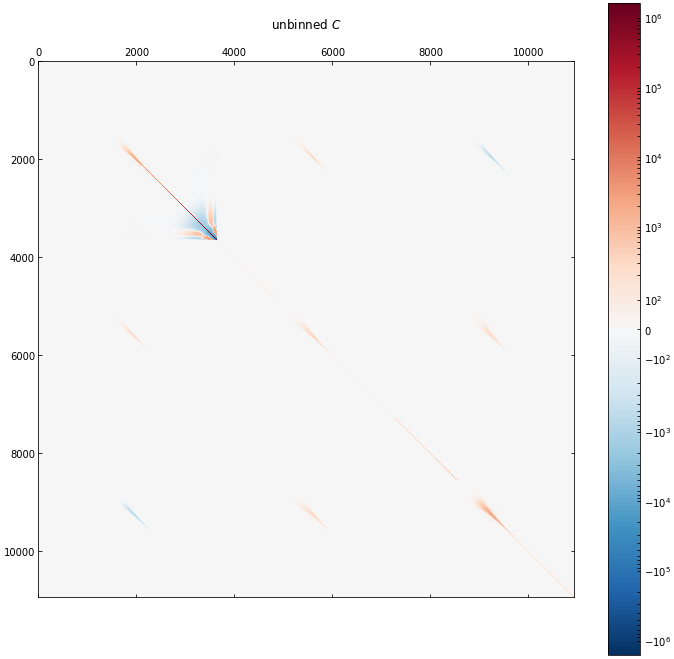

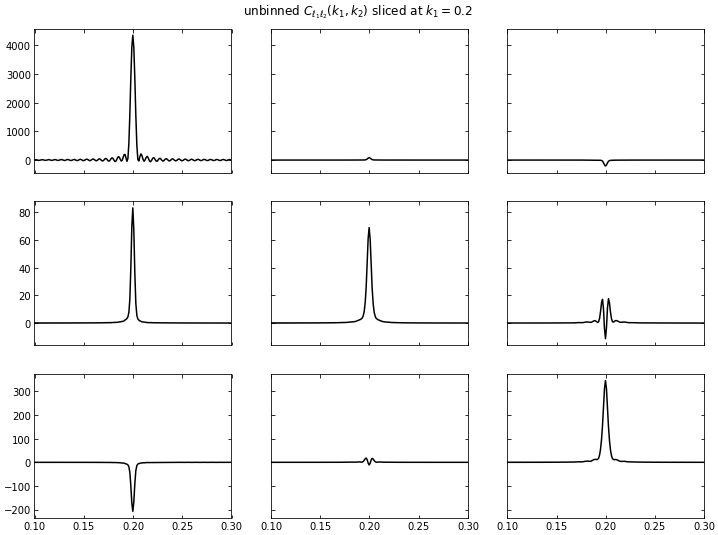

In [17]:
# look at unbinned C

C_ = C * rescale_kk(k, 1.5)

pltmat(C_)
plt.title("unbinned $C$")
plt.show()

kmd = 0.2
idx = abs(k - kmd).argmin()
klo, khi = k[idx] - 0.1, k[idx] + 0.1

_, axes = plt.subplots(nrows=C_.shape[0], ncols=C_.shape[1], sharex=True, sharey='row', figsize=(12, 9))
for i in range(C_.shape[0]):
    for j in range(C_.shape[1]):
        axes[i, j].plot(k, C_[i, j, idx], 'k')
plt.xlim(klo, khi)
plt.suptitle("unbinned $C_{{\ell_1 \ell_2}}(k_1, k_2)$ sliced at $k_1={}$".format(kmd), y=0.92)
plt.show()

In [16]:
# connected piece for ell-ell blocks

Cb_conn_ell = np.load("Cb_conn_z1.npy")

C_conn_ell = np.zeros(Cb_conn_ell.shape[:2] + C.shape[2:])
for i in range(C_conn_ell.shape[0]):
    for j in range(C_conn_ell.shape[1]):
        kb = 0.005 * np.arange(0.5, 123, 1)
        C_conn_ell[i, j] = interp2d(kb, kb, Cb_conn_ell[i, j], fill_value=0)(k, k)

C[1:1+C_conn_ell.shape[0], 1:1+C_conn_ell.shape[1]] += C_conn_ell

In [13]:
%%time

trans_J0 = Hankel(k, nu=0, N=len(k), lowring=lowring)
trans_J0.prefac /= 2 * np.pi
trans_jl = [P2xi(k, l=l, N=len(k), lowring=lowring) for l in range(0, 2*C.shape[0]-1, 2)]
trans = [trans_J0] + trans_jl
# trans = trans_jl

for i in range(C.shape[0]):
    _, C[i] = trans[i](C[i], axis=-2)
for j in range(C.shape[1]):
    _, C[:, j] = trans[j](C[:, j], axis=-1)

/global/homes/t/tiger/.conda/envs/rich/lib/python3.6/site-packages/mcfit/mcfit.py:327: RuntimeWarning: invalid value encountered in true_divide
  ratio = numpy.take(a, [1], axis=axis) / start
/global/homes/t/tiger/.conda/envs/rich/lib/python3.6/site-packages/mcfit/mcfit.py:334: RuntimeWarning: invalid value encountered in true_divide
  ratio = start / numpy.take(a, [-2], axis=axis)


CPU times: user 3min 5s, sys: 2min 48s, total: 5min 54s
Wall time: 5min 54s


KeyboardInterrupt: 

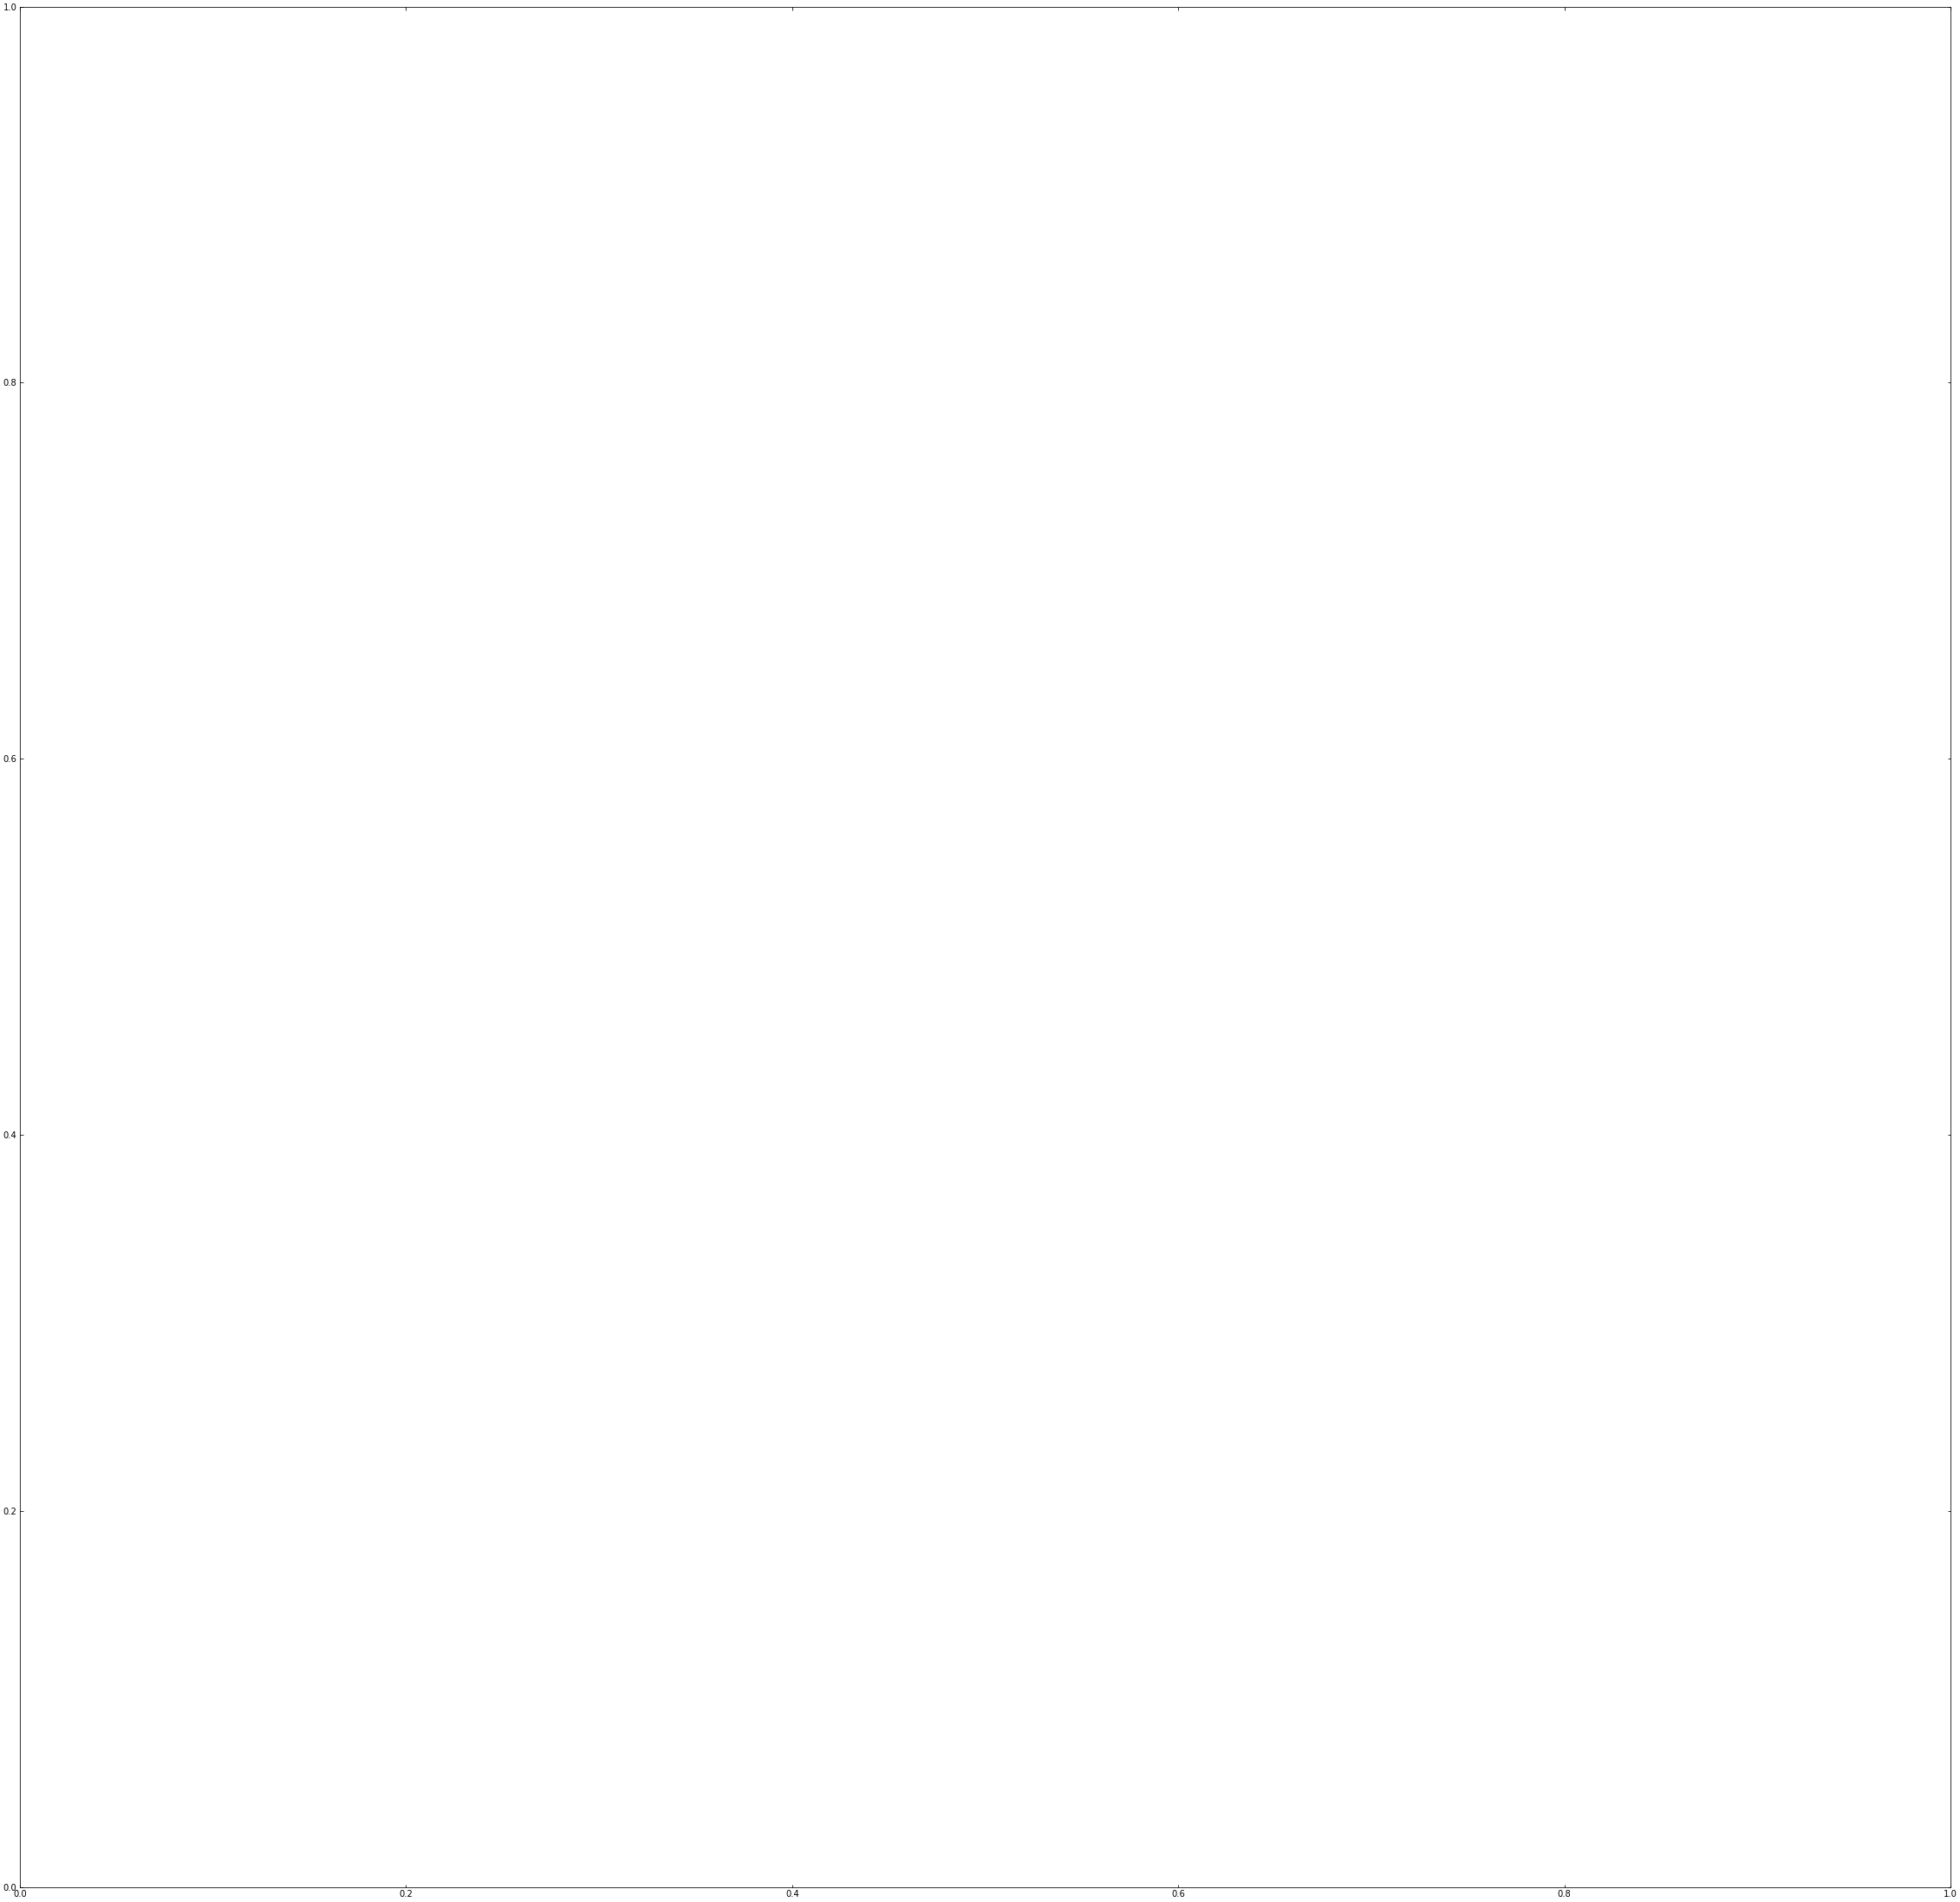

In [723]:
# look at unbinned C

pltmat(C)
plt.title("unbinned $C$")
plt.show()

smd = 50
idx = abs(s - smd).argmin()
slo, shi = s[idx] - 30, s[idx] + 30

_, axes = plt.subplots(nrows=C.shape[0], ncols=C.shape[1], sharex=True, sharey='row', figsize=(12, 9))
for i in range(C.shape[0]):
    for j in range(C.shape[1]):
        axes[i, j].plot(s, C[i, j, idx], 'k')
    axes[i, 0].set_yscale('symlog', linthreshy=1e-6)
plt.xlim(slo, shi)
plt.suptitle("unbinned $C_{{\ell_1 \ell_2}}(s_1, s_2)$ sliced at $s_1={}$".format(smd), y=0.92)
plt.show()

## $P_\ell(k) \leftrightarrow \xi_\ell(s)$

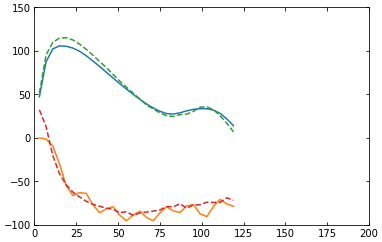

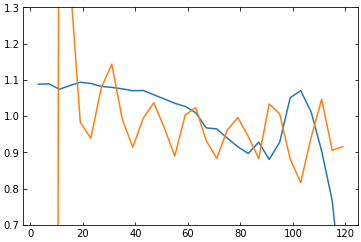

[2.89138350e+05 3.31843742e+02 1.56812950e+00 3.86808065e+00]


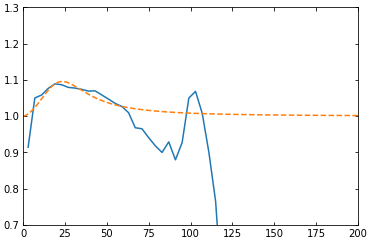

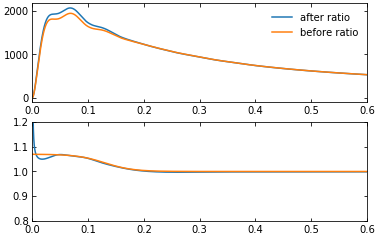

(array([9.95874863e-07, 1.00092044e-06, 1.00599158e-06, ..., 9.80890229e+01, 9.85859886e+01,
        9.90854722e+01]),
 array([4.13972674e+03, 4.17640303e+03, 4.14015254e+03, ..., 6.88892978e-02, 6.81047565e-02,
        6.77161969e-02]))

In [504]:
def get_xils(z_bin=1):
    """Return xi_l(s)"""
    
    if z_bin != 1:
        raise NotImplementedError
        
    xil_file = f"z1/multipoles.dat"
    xil_data = np.loadtxt(xil_file, unpack=True)
    s = xil_data[0]
    xi = xil_data[1:]
    
    return s, xi

def get_xils_from_Plk(k, z_bin):
    P = get_Plk(k, z_bin, add_shot=False)
#     P = get_Plk(k, z_bin, add_shot=False, kcut=1) - P
    xi = np.zeros_like(P)
    for i in range(P.shape[0]):
        l = 2 * i
        s, xi[i] = P2xi(k, l=l, lowring=(l==0))(P[i], extrap=False)
    return s, xi

def plt_xils(k, z_bin=1):
    s_, xi_ = get_xils_from_Plk(k, z_bin)
    xi_ = xi_[:2]
    
    s, xi = get_xils(z_bin)
    
    # bin theory
    s_bin = s - np.diff(s).mean() / 2
    s_bin = np.append(s_bin, s_bin[-1] + np.diff(s).mean())
    xi_, _ = avg(s_, xi_, s_bin, w=s_**2, axis=1)
    
    plt.plot(s, (s**2 * xi_).T)
    plt.plot(s, (s**2 * xi).T, ls='--')
    
    plt.xlim(0, 200)
#     plt.xscale('log')
    plt.ylim(-100, 150)
#     plt.yscale('symlog', linthreshy=1)
    plt.show()
    
    plt.plot(s, (xi / xi_).T)
    plt.ylim(0.7, 1.3)
    plt.show()

def hack_P0(k, z_bin=1, plot=True):
    s_, xi_ = get_xils_from_Plk(k, z_bin)
    xi_ = xi_[0]
    s, xi = get_xils(z_bin)
    xi = xi[0]
    ratio = xi / interp1d(s_, xi_)(s)
    
    def ratio_fit(s, a, b, c, d):
#         return (a + b*s**c + s)**d / (a**d + s**d)
#     abcd, _ = curve_fit(ratio_fit, s[s<70], ratio[s<70], p0=[100, 1, 0.5, 2])
        return (a + b*s**c + s**d) / (a + s**d)
    abcd, _ = curve_fit(ratio_fit, s[s<70], ratio[s<70], p0=[5000, 100, 1, 2])
    print(abcd)
    
#     s_hack = np.insert(s[4:], 0, 0)
#     ratio_hack = ratio[3:]
#     s_hack = np.append(s_hack, 150)  # tune this!
#     ratio_hack = np.append(ratio_hack, ratio_hack[-1])
    
    if plot:
        l, = plt.plot(s, ratio)
#         plt.plot(s_hack, ratio_hack, c=l.get_color(), ls='--')
#         plt.plot(s_, ratio_fit(s_, 1000, 20, 1, 2), ls='--')
        plt.plot(s_, ratio_fit(s_, *abcd), ls='--')
        plt.xlim(0, 200)
        plt.ylim(0.7, 1.3)
        plt.show()
    
    k, P0_ = xi2P(s_, l=0, lowring=True)(xi_, extrap=False)
    xi_ *= ratio_fit(s_, *abcd)
    k, P0 = xi2P(s_, l=0, lowring=True)(xi_, extrap=False)
    
    if plot:
        plt.subplot(211)
        plt.plot(k, k*P0, label='after ratio')
        plt.plot(k, k*P0_, label='before ratio')
#         plt.plot(k, P0, label='after ratio')
#         plt.plot(k, P0_, label='before ratio')
        plt.xlim(0, 0.6)
#         plt.xscale('log')
#         plt.yscale('log')
#         plt.ylim(1e2, 1e5)
        plt.legend()
        plt.subplot(212)
        plt.plot(k, P0 / P0_)
        plt.plot(k, 1 + 0.035*(1 - np.tanh((k-0.13)/0.05)))
        plt.xlim(0, 0.6)
#         plt.xscale('log')
        plt.ylim(0.8, 1.2)
        plt.show()
    
#     P0_ *= 1 + 0.035*(1-np.tanh(4*(np.log(k/0.09))))
#     s_, xi_ = P2xi(k, l=0, lowring=True)(P0, extrap=False)
#     s_, xi_ = P2xi(k, l=0, lowring=True)(P0_, extrap=False)
#     plt.plot(s_, s_**2 * xi_)
#     s, xi = get_xils(z_bin)
#     plt.plot(s, s**2 * xi[0], ls='--')
#     plt.xlim(0, 200)
#     plt.ylim(-100, 150)
#     plt.show()
    
    return k, P0

plt_xils(k)
hack_P0(k)

/global/homes/t/tiger/.conda/envs/rich/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/global/homes/t/tiger/.conda/envs/rich/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in multiply


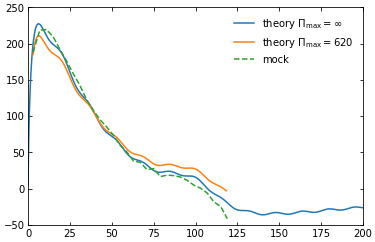

In [609]:
def get_wrp(z_bin=1):
    """Return w(rp)"""
    
    if z_bin != 1:
        raise NotImplementedError
        
    w_file = f"z1/wgg1.dat"
    rp, w = np.loadtxt(w_file, unpack=True)
    
    return rp, w

def get_wrp_from_Pperp(k, z_bin):
    P = get_Pperp(k, z_bin, add_shot=False)
    rp, w = Hankel(k, nu=0)(P, extrap=False)
    w /= 2 * np.pi
    return rp, w

def get_wrp_from_Plk(k, z_bin, Pi_max):    
    P = get_Plk(k, z_bin, add_shot=False)
    xi = []
    for i in range(P.shape[0]):
        l = 2 * i
        xi.append(CubicSpline(* P2xi(k, l=l, lowring=(l==0))(P[i], extrap=False)))
    
    rp = pi = s[s < s.max() / np.sqrt(2)]
    rp = rp.reshape(-1, 1)
    r = np.sqrt(rp**2 + pi**2)
    mu = pi / r
    w = xi[0](r) + xi[1](r) * legendre(2)(mu) + xi[2](r) * legendre(4)(mu)
    Q = get_Qrppi()
    Q = Q(pi, rp.squeeze())
    
    w, _ = avg(pi, w*Q, [0, Pi_max], axis=1)
    norm, _ = avg(pi, Q, [0, Pi_max], axis=1)
    w *= 1 / norm

    return rp.squeeze(), w.squeeze()

def plt_wrp(k, z_bin=1):
    rp, w = get_wrp_from_Pperp(k, z_bin)
    plt.plot(rp, rp * w, label="theory $\Pi_\mathrm{max} = \infty$")
    
    Pi_max = 620
    
    rp, w = get_wrp_from_Plk(k, z_bin, Pi_max)
    plt.plot(rp, rp * w * Pi_max, label=f"theory $\Pi_\mathrm{{max}} = {Pi_max}$")
    
    rp, w = get_wrp(z_bin)
    plt.plot(rp, rp * w * Pi_max, ls='--', label="mock")
    
    plt.xlim(0, 200)
    plt.ylim(-50, 250)
    plt.legend()
    plt.show()

plt_wrp(k)

## re-bin for band power

In [14]:
smin, smax = 1, 121

ds_bin = 4

bins = np.arange(smin, smax+ds_bin/2, ds_bin)

bincen = .5*bins[:-1]+.5*bins[1:]
Nb = len(bins) - 1
Vb = 4*np.pi/3 * bins**3
Vb = Vb[1:] - Vb[:-1]

In [15]:
def get_invQls(bins, l_inv_max, z_bin):
    """Return Q^{-1}_{W,l}(s) for all (l, s)"""
    w_type = 'w_w'
    
    Ql_file = f"patchy/Ql_model_z{z_bin}_{w_type}.dat"
    Ql_data = np.loadtxt(Ql_file, unpack=True)
    s = Ql_data[0]
    Q = Ql_data[1:]
    
    Q, _ = avg(s, Q, bins, w=s**2, axis=1)
    
    Q *= get_const(z_bin)['alpha_Q']**2
    
    invQ = inv_pole(Q, l_inv_max)
    
    return invQ

def get_invQperp(bins, z_bin):
    """Return 1 / Q_{W,perp}(s)"""
    w_type = 'w_w'
    
    Ql_file = f"patchy/Qperp_data_z{z_bin}_{w_type}.dat"
    s, Q = np.loadtxt(Ql_file, unpack=True)
    
    assert np.allclose(s, 0.5 * (bins[1:] + bins[:-1]))
    
    # this is the normalization, for which Sukhdeep uses effectively "DR"
    Q *= get_sukhdeep_const(z_bin)['alpha_P']
    
    return 1 / Q

def get_invQlls(bins, l_max, lp_max, l_invQ_max, z_bin, include_perp=True):
    """Return Q^{-1}_{W,ll}(s) for all (l, l', s)
    
    Also prepend the Q^{-1}_perp in front
    """
    invQls = get_invQls(bins, l_invQ_max, z_bin)
    
    ell = get_ell(l_max)
    ell_prime = get_ell(lp_max)
    
    invQ = np.zeros((len(ell), len(ell_prime), len(bins) - 1))
    
    for i, l in enumerate(ell):
        for j, lp in enumerate(ell_prime):
            for l_Q in range(abs(l-lp), min(l+lp, l_invQ_max) + 1, 2):
                w3sq = wigner_3j(l, lp, l_Q, 0, 0, 0)**2
                invQ[i, j] += (2*l+1) * float(w3sq) * invQls[l_Q//2]
    
    if include_perp:
        invQ_ = invQ
        invQ = np.zeros((1 + len(ell), 1 + len(ell_prime), len(bins) - 1))
        invQ[0, 0] = get_invQperp(bins, z_bin)
        invQ[1:, 1:] = invQ_
            
    return invQ

In [16]:
%%time

def get_Cb(C, s, bins, axis=(-1, -2), deg=1):
    Cb, _  = avg(s, C, bins, w=s**2, k=deg, axis=axis[0])
    Cb, _  = avg(s, Cb, bins, w=s**2, k=deg, axis=axis[1])
    
    return Cb

Cb = get_Cb(C, s, bins, deg=3)
# np.save("Cb_proj-pole.npy", Cb)

# Cb = np.load("Cb_proj-pole.npy")

rb = cov2cor(Cb)

CPU times: user 5min 15s, sys: 1min 12s, total: 6min 28s
Wall time: 5min 45s


In [17]:
def renorm_Cb(Cb, bins, l_max, z_bin=1, include_perp=True):
    """Return Cb renormalized with correlation function denominator"""
    
    if include_perp:
        Cb_renorm = np.zeros((2 + l_max//2,) * 2 + Cb.shape[2:])
        lp_max = 2 * Cb.shape[0] - 4
    else:
        Cb_renorm = np.zeros((1 + l_max//2,) * 2 + Cb.shape[2:])
        lp_max = 2 * Cb.shape[0] - 2
    
    l_invQ_max = 10
    invQ = get_invQlls(bins, l_max, lp_max, l_invQ_max, z_bin, include_perp)
    
    for i in range(Cb.shape[0]):
        for j in range(Cb.shape[1]):
            Cb_renorm += invQ[:, i][:, None, :, None] * Cb[[i], [j]] * invQ[:, j][None, :, None, :]
    Cb_renorm *= get_const(z_bin)['W0']**2
    
    return Cb_renorm

Cb_renorm = renorm_Cb(Cb, bins, 2)
# Cb_renorm = renorm_Cb(Cb, bins, 4, include_perp=False)
rb_renorm = cov2cor(Cb_renorm)

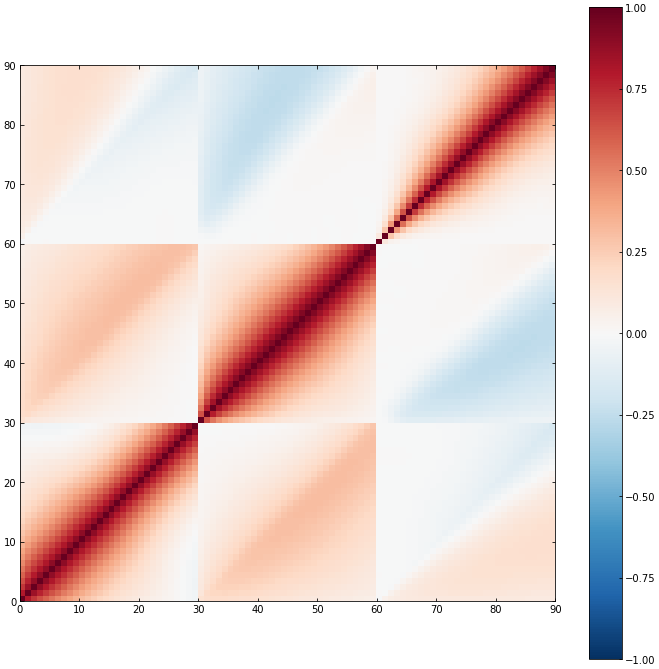

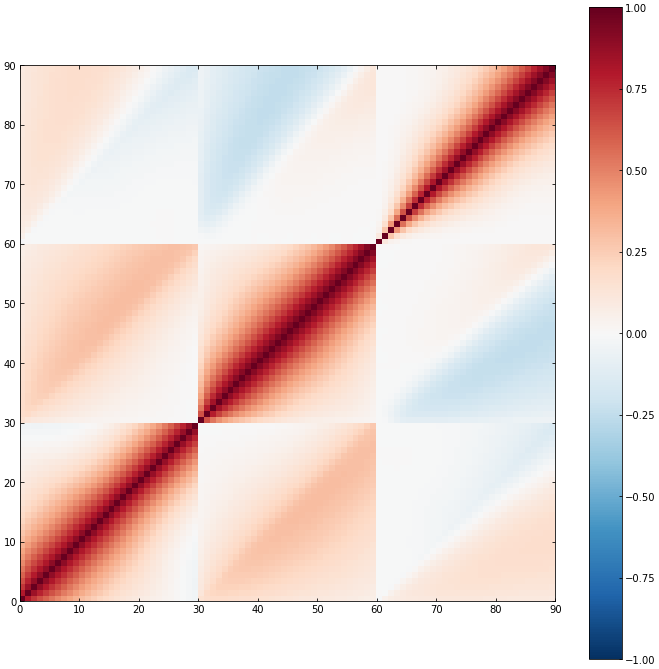

/global/homes/t/tiger/.conda/envs/rich/lib/python3.6/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


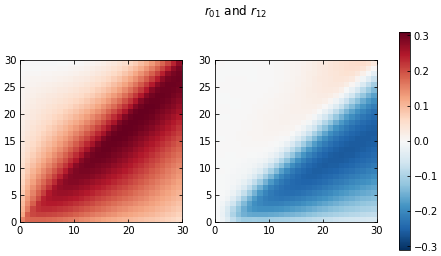

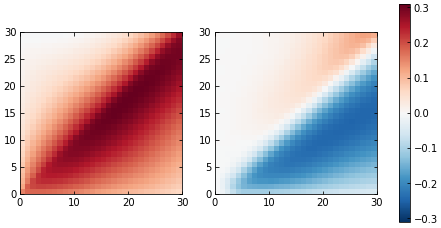

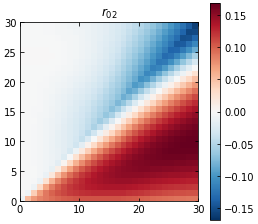

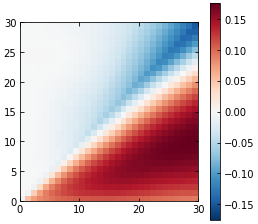

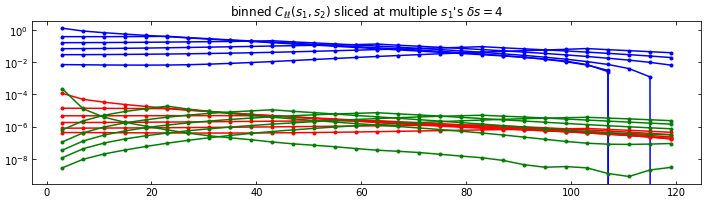

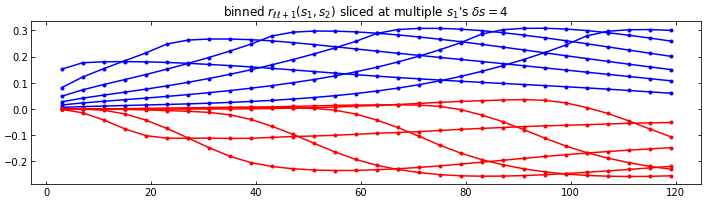

In [18]:
# visualize binned covariance Cb

pltmat(rb[:3, :3], scale='linear')
pltmat(rb_renorm, scale='linear')

pltmat([rb[0, 1], rb[1, 2]], scale='linear')
plt.suptitle("$r_{01}$ and $r_{12}$")
pltmat([rb_renorm[0, 1], rb_renorm[1, 2]], scale='linear')

pltmat(rb[0, 2], scale='linear')
plt.title("$r_{02}$")
pltmat(rb_renorm[0, 2], scale='linear')

ds_slice = 20
idx = abs(bins - np.arange(smin, smax, ds_slice)[:, None]).argmin(axis=1)

plt.figure(figsize=(12, 3))
plt.plot(bincen, Cb[0, 0, idx].T, marker='.', c='b')
plt.plot(bincen, Cb[1, 1, idx].T, marker='.', c='r')
plt.plot(bincen, Cb[2, 2, idx].T, marker='.', c='g')
plt.title("binned $C_{\ell\ell}(s_1, s_2)$ sliced at multiple $s_1$'s $\delta s=4$")
plt.yscale('log')
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(bincen, rb[0, 1, idx].T, marker='.', c='b')
plt.plot(bincen, rb[1, 2, idx].T, marker='.', c='r')
plt.title("binned $r_{\ell\ell+1}(s_1, s_2)$ sliced at multiple $s_1$'s $\delta s=4$")
plt.show()

In [40]:
%%time

def get_Cb_data(bootstrap=False):
    corrfunc_data = np.stack([np.load("z1/wgg1_all.npy"), 
                        np.load("z1/m0_all.npy"),
                        np.load("z1/m2_all.npy")], axis=1)
    shape = corrfunc_data.shape
    
    corrfunc_data = corrfunc_data.reshape(shape[0], -1)
    
    if bootstrap:
        choice = np.random.choice(shape[0], size=shape[0], replace=True)
        corrfunc_data = corrfunc_data[choice]
    
    Cb_data = np.cov(corrfunc_data, rowvar=False)
    Cb_data = Cb_data.reshape(shape[1:] * 2).swapaxes(1, 2)
    
    Cb_data = Cb_data[..., :len(bincen), :len(bincen)]
    
    return Cb_data

def bootstrap_Cb_data(N=1000):
    Cb_data = get_Cb_data()
    
    Cb_data_boot = np.zeros(Cb_data.shape + (N,))
    
    np.random.seed(0)
    for i in range(N):
        Cb_data_boot[..., i] = get_Cb_data(bootstrap=True)
    Cb_data_err = Cb_data_boot.std(axis=-1)
    
    return Cb_data, Cb_data_err

Cb_data, Cb_data_err = bootstrap_Cb_data()

rb_data = cov2cor(Cb_data)
rb_data_err = cov2cor(Cb_data_err, Cb_renorm)

# np.savez("fig/covcf_data.npz", s=bincen, Cb=Cb_data, rb=rb_data)
# np.savez("fig/covcf_err.npz", s=bincen, Cb=Cb_data_err, rb=rb_data_err)

CPU times: user 2.58 s, sys: 2.41 s, total: 4.99 s
Wall time: 2.5 s


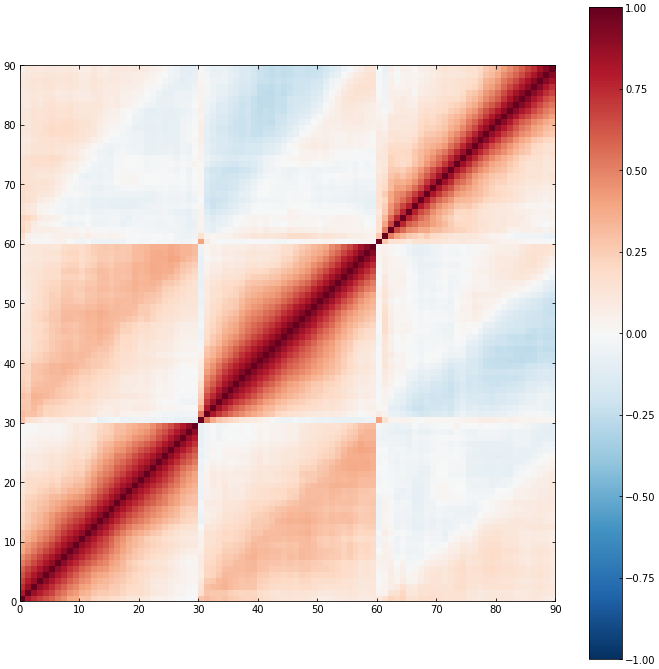

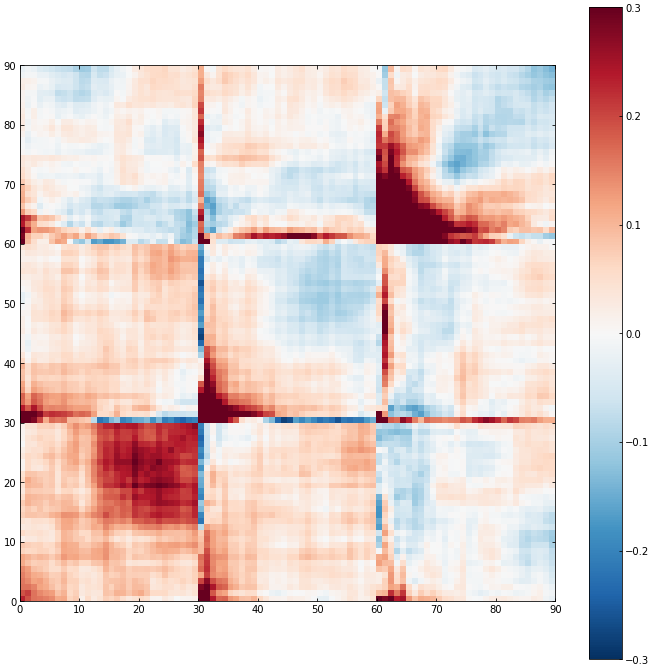

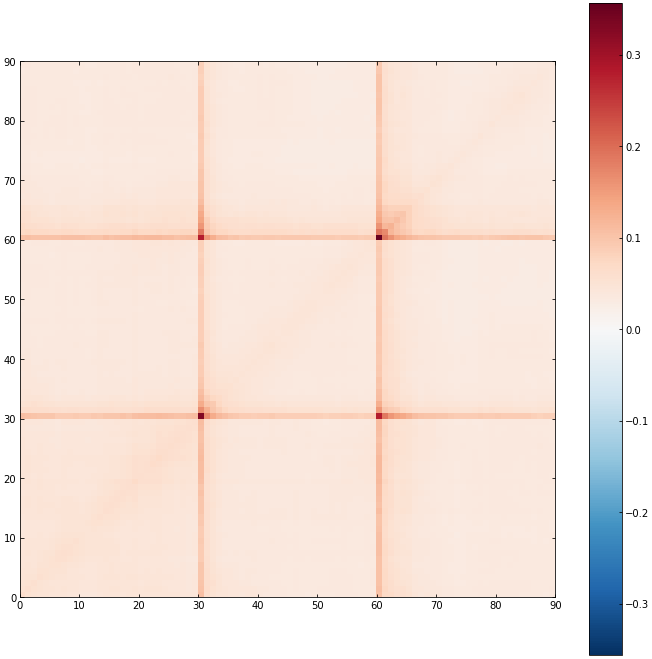

In [41]:
# Cb_data = np.loadtxt("z1/combined_cov_wgg800_wgg1_m0_m2.dat").reshape(4, 30, 4, 30).swapaxes(1, 2)
# Cb_data = Cb_data[2:, 2:]
# Cb_data = Cb_data[1:, 1:]
# rb_data = cov2cor(Cb_data)
pltmat(rb_data, scale='linear', vlim=1)

Cb_diff = Cb_data - Cb_renorm
rb_diff = cov2cor(Cb_diff, Cb_renorm)
pltmat(rb_diff, scale='linear', vlim=.3)

pltmat(rb_data_err, scale='linear')

# np.savez("fig/covcf_analytic.npz", s=bincen, Cb=Cb_renorm, rb=rb_renorm)
# np.savez("fig/covcf_diff.npz", s=bincen, Cb=Cb_diff, rb=rb_diff)

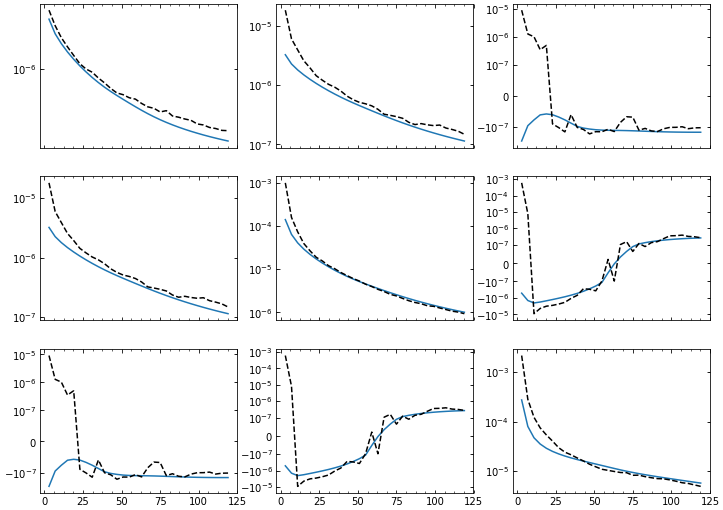

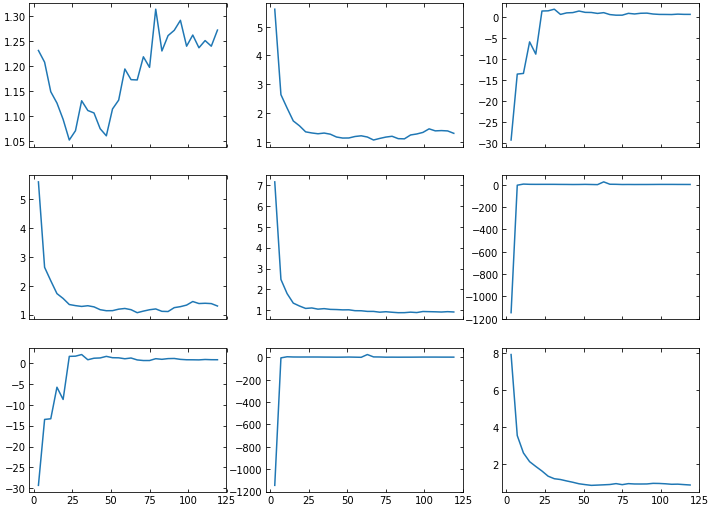

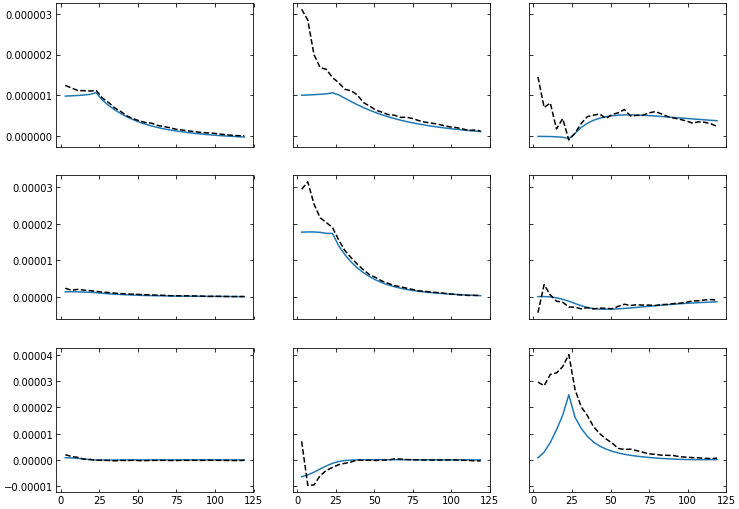

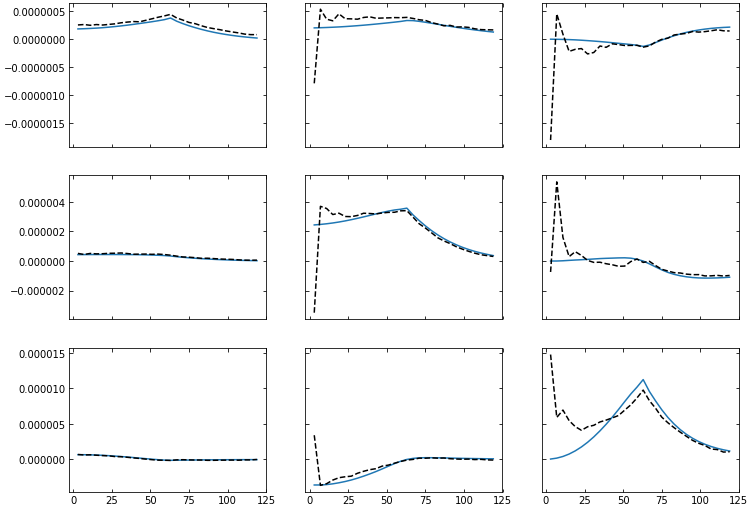

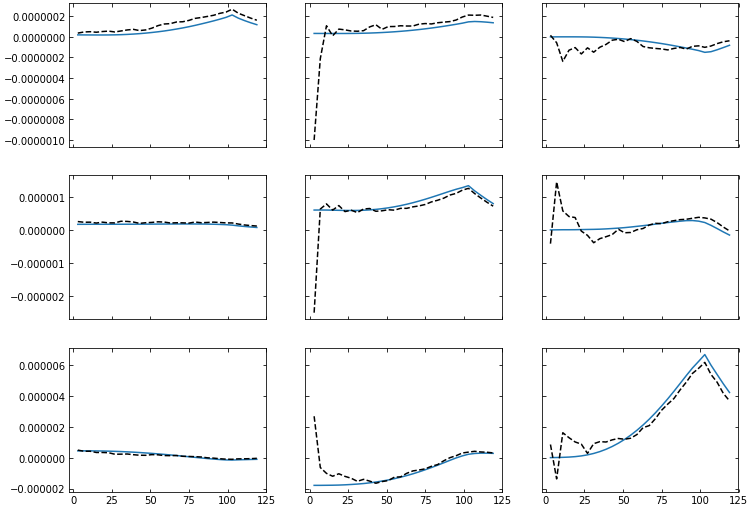

In [37]:
_, axes = plt.subplots(3, 3, sharex=True, sharey=False, figsize=(12, 9))
for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        ax.plot(bincen, Cb_renorm[i, j].diagonal())
#         ax.plot(bincen, Cb[i, j].diagonal())
        ax.plot(bincen, Cb_data[i, j].diagonal(), 'k--')
        ax.set_yscale('symlog', linthreshy=1e-7)
        plt.minorticks_on()
plt.show()

_, axes = plt.subplots(3, 3, sharex=True, sharey=False, figsize=(12, 9))
for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        ax.plot(bincen, Cb_data[i, j].diagonal() / Cb_renorm[i, j].diagonal())
plt.show()

_, axes = plt.subplots(3, 3, sharex=True, sharey='row', figsize=(12, 9))
for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        ax.plot(bincen, Cb_renorm[i, j, 5])
#         ax.plot(bincen, Cb[i, j, 5])
        ax.plot(bincen, Cb_data[i, j, 5], 'k--')
plt.show()

_, axes = plt.subplots(3, 3, sharex=True, sharey='row', figsize=(12, 9))
for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        ax.plot(bincen, Cb_renorm[i, j, 15])
#         ax.plot(bincen, Cb[i, j, 15])
        ax.plot(bincen, Cb_data[i, j, 15], 'k--')
plt.show()

_, axes = plt.subplots(3, 3, sharex=True, sharey='row', figsize=(12, 9))
for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        ax.plot(bincen, Cb_renorm[i, j, 25])
#         ax.plot(bincen, Cb[i, j, 25])
        ax.plot(bincen, Cb_data[i, j, 25], 'k--')
plt.show()